In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.model_selection import train_test_split
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import LearningRateScheduler, EarlyStopping

## Loading the Data

In [2]:
df = pd.read_csv('./Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/IND_and_Nep_AQI_Dataset.csv')
df.head()

,Location,Filename,Year,Month,Day,Hour,AQI,PM2.5,PM10,O3,CO,SO2,NO2,AQI_Class
0,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-9.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
1,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-8.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
2,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-7.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
3,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-6.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy
4,"Biratnagar, Nepal",BRI_Un_2023-02-02- 12.00-5.jpg,2023,2,2,12:00,158,70.08,100.82,58.89,0.49,4.4,1.04,d_Unhealthy


In [3]:
def getImageData(dirPath, filenames):
    images = []
    for filename in filenames:
        img = cv2.imread(dirPath+filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype("float16") / 255.0
        images.append(img)
    return np.array(images)
    
location = "./Air Pollution Image Dataset/Air Pollution Image Dataset/Combined_Dataset/All_img/"
data = getImageData(location, df['Filename'].values.tolist())

## Printing Sample Images

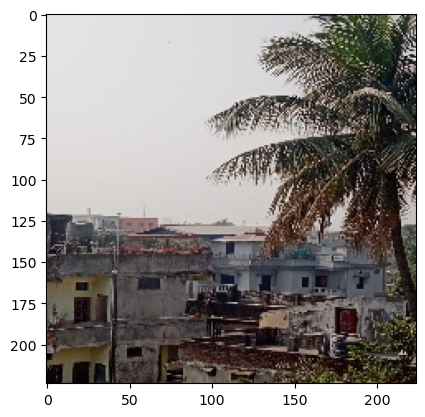

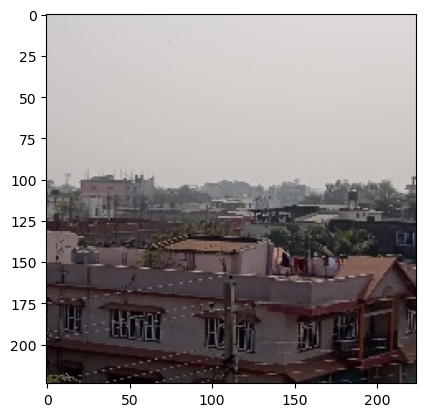

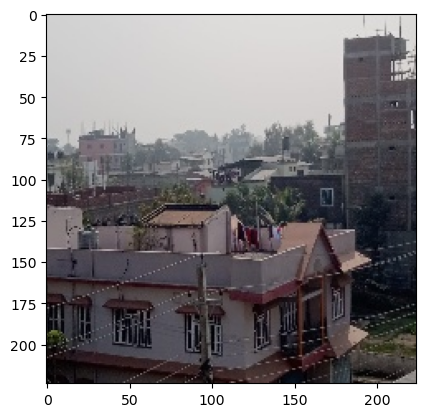

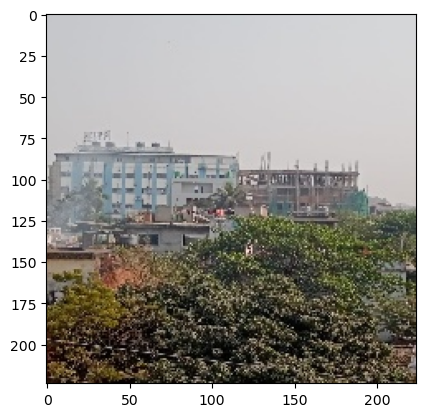

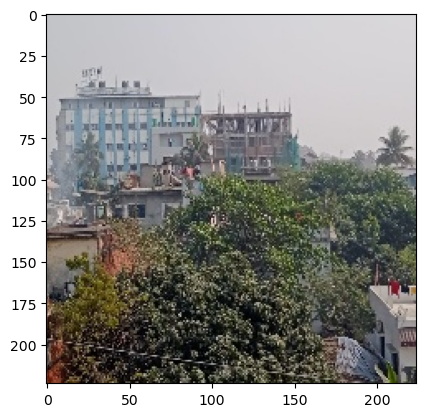

In [4]:
for i in range(5):
    plt.imshow((data[i] * 255).astype("uint8"))
    plt.show()

## Dataset Exploration

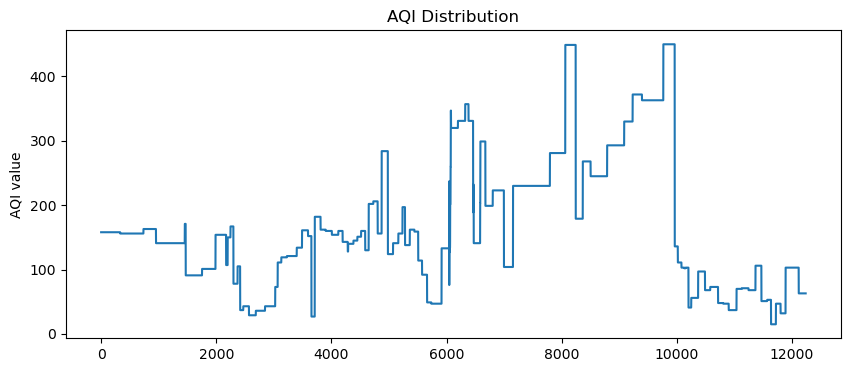

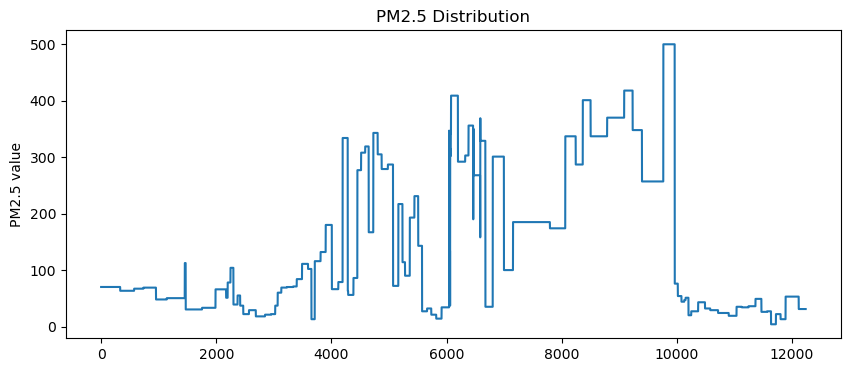

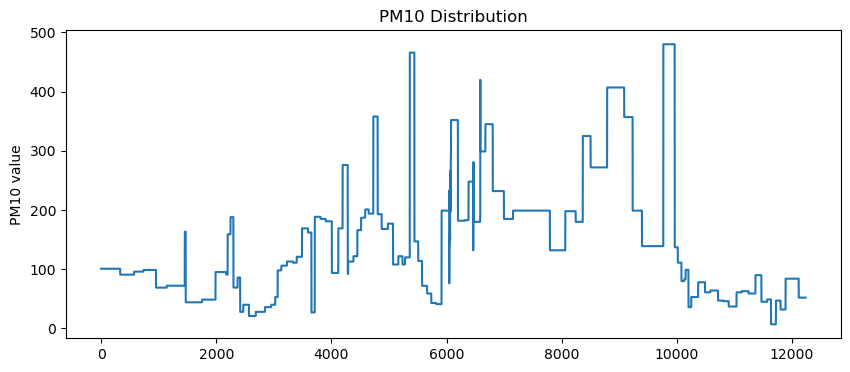

In [5]:
cols = ['AQI', 'PM2.5', 'PM10']
for c in cols:
    plt.figure(figsize=(10, 4))
    plt.plot(df[c])
    plt.ylabel("{} value".format(c))
    plt.title("{} Distribution".format(c))
    plt.show()

## PM10 Prediction

In [6]:
X = data
y = df['PM10'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

### Building a basic CNN model from scratch

In [7]:
input_layer = Input(shape=(224, 224, 3))

x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)

x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

output_layer = Dense(1, activation='linear')(x)  # Regression problem
cnnModel = Model(inputs=input_layer, outputs=output_layer)

In [8]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [9]:
cnnModel.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
cnnModel.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 54, 54, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 128)       73856

In [10]:
history = cnnModel.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), verbose=1, callbacks=[earlyStopping])

Epoch 1/50


153/153 [==============================] - 283s 2s/step - loss: 10573.2471 - mae: 75.8792 - val_loss: 8956.6729 - val_mae: 63.7234
Epoch 2/50
153/153 [==============================] - 294s 2s/step - loss: 7101.2583 - mae: 61.0738 - val_loss: 5257.2954 - val_mae: 50.0468
Epoch 3/50
153/153 [==============================] - 317s 2s/step - loss: 5708.1455 - mae: 54.2292 - val_loss: 4230.3975 - val_mae: 47.4801
Epoch 4/50
153/153 [==============================] - 319s 2s/step - loss: 5173.2715 - mae: 51.6073 - val_loss: 3739.9473 - val_mae: 42.8196
Epoch 5/50
153/153 [==============================] - 319s 2s/step - loss: 4561.8101 - mae: 48.5240 - val_loss: 3382.3376 - val_mae: 40.5355
Epoch 6/50
153/153 [==============================] - 331s 2s/step - loss: 3872.1196 - mae: 44.9700 - val_loss: 3842.1675 - val_mae: 42.9154
Epoch 7/50
153/153 [==============================] - 313s 2s/step - loss: 3492.8721 - mae: 42.5550 - val_loss: 2818.7231 - val_mae: 36.1310
Epoch 8/50

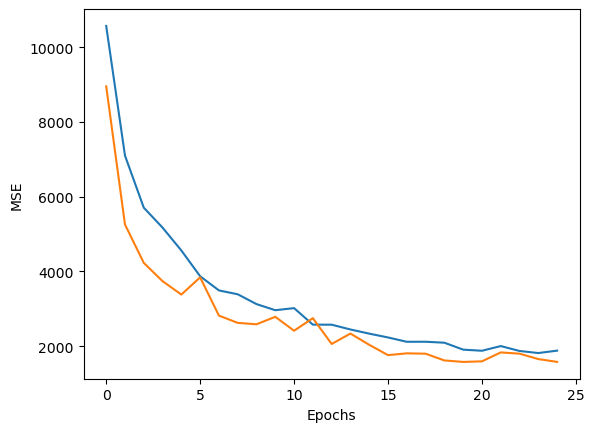

In [11]:
train_loss = history.history['loss']  
val_loss = history.history['val_loss']
plt.plot(train_loss)
plt.plot(val_loss)
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()

In [14]:
y_pred = cnnModel.predict(X_test)
y_pred

77/77 [==============================] - 8s 79ms/step


array([[129.25015 ],
       [ 82.366585],
       [ 52.8002  ],
       ...,
       [127.23786 ],
       [ 91.802864],
       [ 36.976547]], dtype=float32)

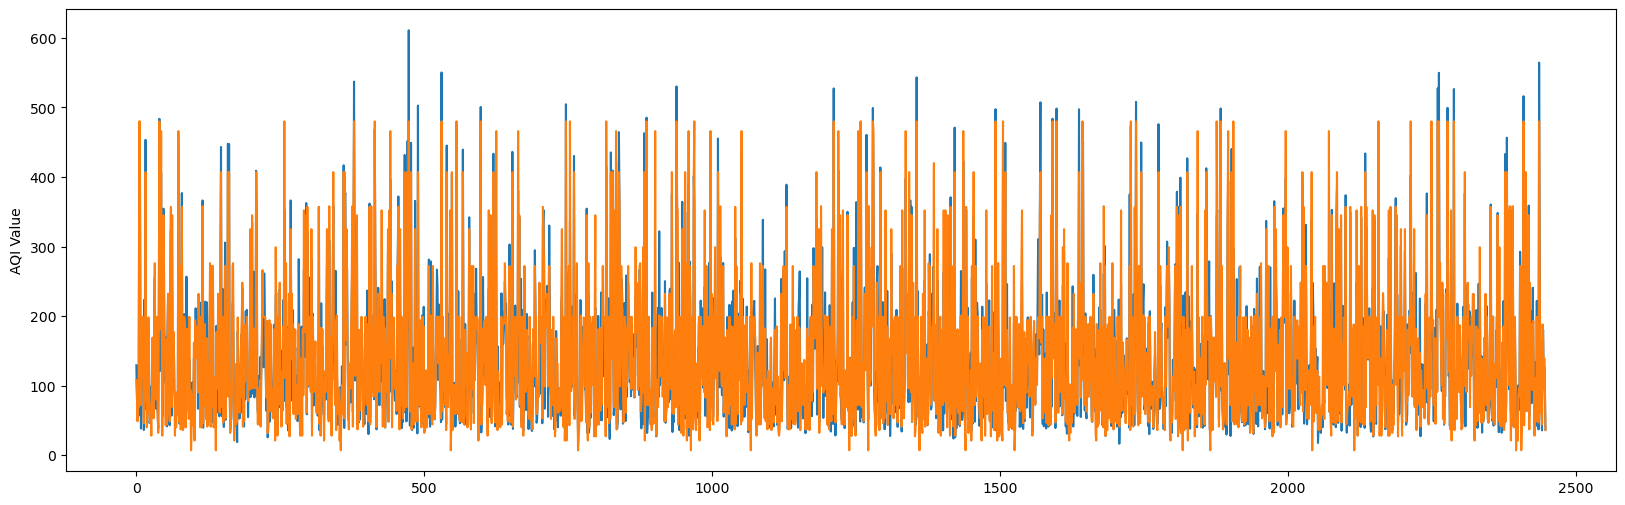

In [15]:
plt.figure(figsize=(20, 6))
plt.ylabel("AQI Value")
plt.plot(y_pred)
plt.plot(y_test)
plt.show()

#### Zoomed in view

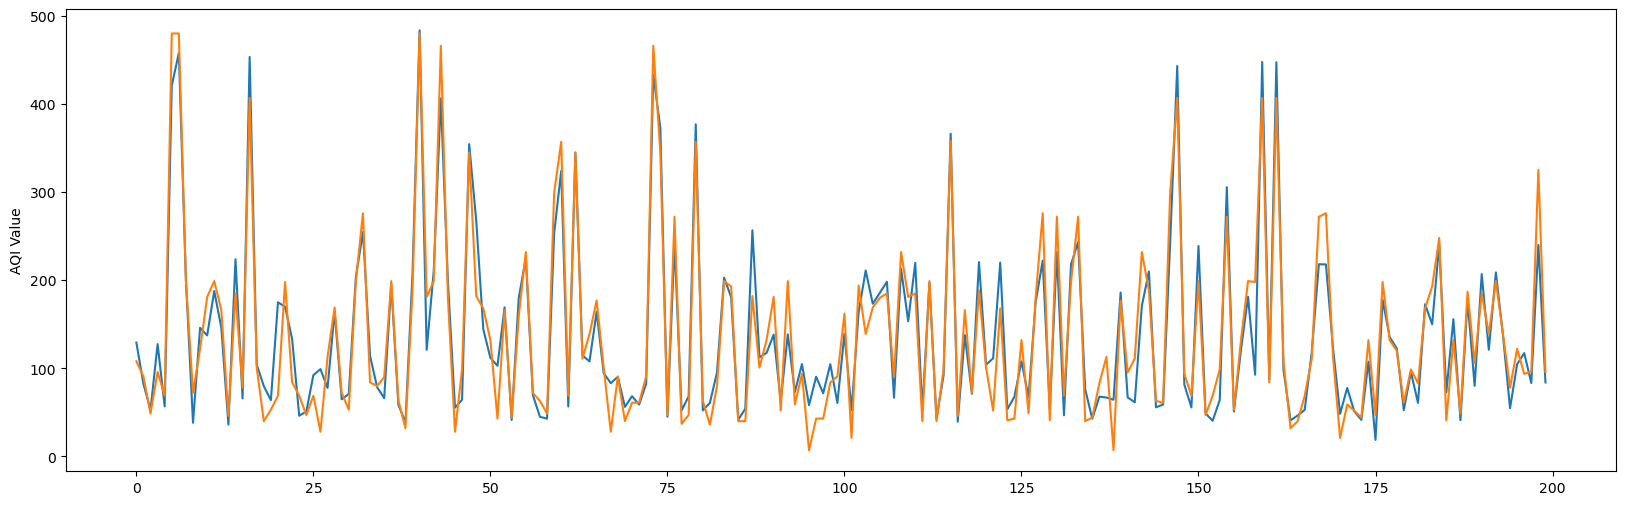

In [16]:
plt.figure(figsize=(20, 6))
plt.ylabel("AQI Value")
plt.plot(y_pred[:200])
plt.plot(y_test[:200])
plt.show()